# 2D XMCD images analysis: Stripe rotation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy import fftpack
import matplotlib.colors as colors
from scipy.ndimage.interpolation import geometric_transform
import seaborn as sns
from scipy.optimize import curve_fit
import pandas as pd

In [2]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    "font.size": 8})
plt.rc('text', usetex=True)

In [3]:
def topolar(img, order=1):
    """
    Transform img to its polar coordinate representation.

    order: int, default 1
        Specify the spline interpolation order. 
        High orders may be slow for large images.
    """
    # max_radius is the length of the diagonal 
    # from a corner to the mid-point of img.
    max_radius = 0.5*np.linalg.norm( img.shape )

    def transform(coords):
        # Put coord[1] in the interval, [-pi, pi]
        theta = 2*np.pi*coords[1] / (img.shape[1] - 1.)

        # Then map it to the interval [0, max_radius].
        #radius = float(img.shape[0]-coords[0]) / img.shape[0] * max_radius
        radius = max_radius * coords[0] / img.shape[0]

        i = 0.5*img.shape[0] - radius*np.sin(theta)
        j = radius*np.cos(theta) + 0.5*img.shape[1]
        return i,j

    polar = geometric_transform(img, transform, order=order)

    rads = max_radius * np.linspace(0,1,img.shape[0])
    angs = np.linspace(0, 2*np.pi, img.shape[1])

    return polar, (rads, angs)

def gaus(x,a,x0,sigma,c0):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))+c0

In [4]:
#scale
pixels = 375
totsize = 15 #um
px_size = totsize*1000/pixels #in nm
print(px_size)

40.0


## Read data

In [5]:
np.concatenate((np.arange(1,31),np.arange(34,44),[45],[44],np.arange(46,51),np.arange(52,55)))

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 34, 35, 36, 37,
       38, 39, 40, 41, 42, 43, 45, 44, 46, 47, 48, 49, 50, 52, 53, 54])

In [7]:
path = '2D_XMCD_processed_data/'
xmcd = []
field = []

for i in np.arange(19):
    fname = 'xmcd_%02d_h.npz' % i
    filename = path + fname
    data = np.load(filename)
    xmcd.append(data['xmcd'])
    field.append(data['field'])

xmcd = np.array(xmcd)
field = np.array(field)

In [8]:
xmcd.shape

(19, 352, 352)

## Rotation of stripes

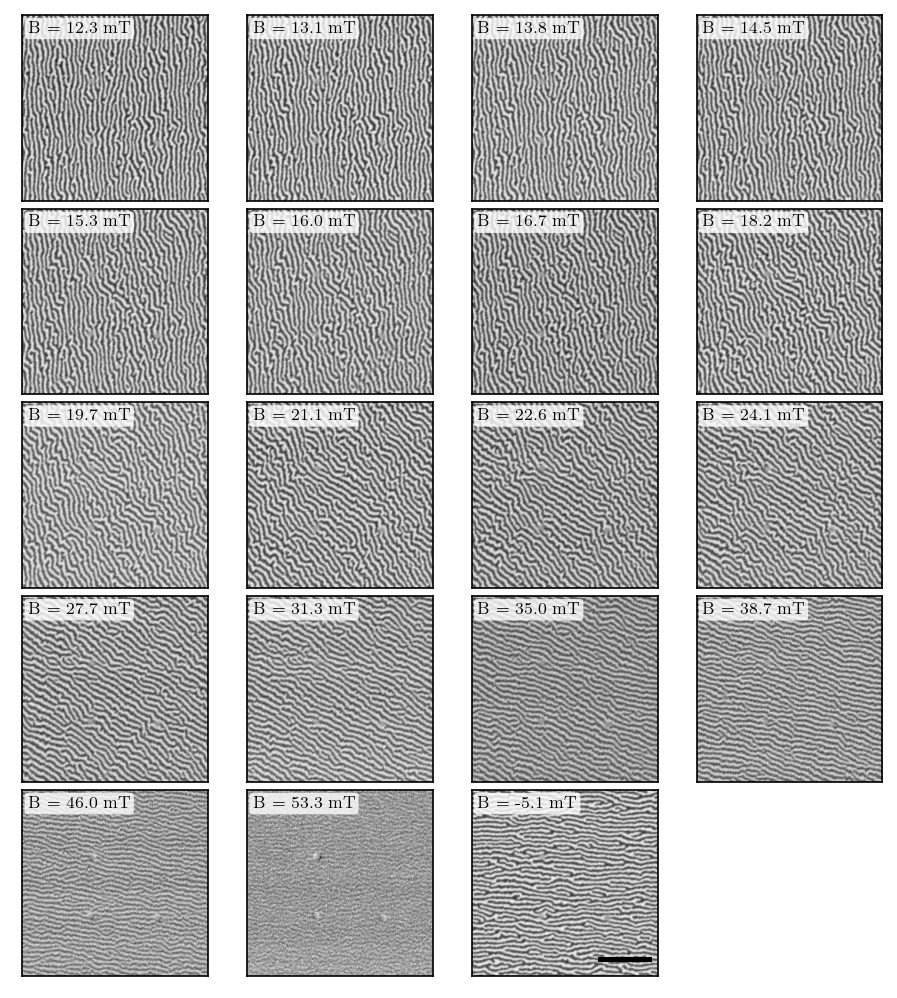

In [9]:
nscans = xmcd.shape[0]

cols = 4
rows = int(nscans/cols) + nscans % cols
plt.figure(figsize=(6,9), dpi = 150)
tup = []

# Loops to create subplot coordinates
for i in np.arange(0, rows, 1):
        for j in np.arange(0, cols, 1):
            tup.append((i, j))
            
# Plots the same image at different phases.
for i in np.arange(0, nscans, 1):
    ax1 = plt.subplot2grid((rows, cols), tup[i], rowspan=1, colspan=1)
    if i==nscans-1:
        plt.arrow(340, 30, -100, 0, width=5, head_width=0, color='black')
        
    plt.text(10, 318, 'B = %.1lf mT' % field[i], color="black",
        bbox={'boxstyle': 'Round','facecolor': 'white', 'edgecolor': 'None', 'alpha': 0.8, 'pad': 0.2})
    plt.imshow(xmcd[i],
           origin='lower',
           cmap = 'Greys')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout(pad=0.05)
plt.show()

### Calculating the average direction of the stripes

In [10]:
S2 = np.zeros_like(xmcd)
for i in np.arange(S2.shape[0]):
    S_aux = np.abs(sp.fftpack.fftshift(sp.fftpack.fft2(xmcd[i,:,:])))
    S2[i,:,:] = np.rot90(S_aux*S_aux)

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.


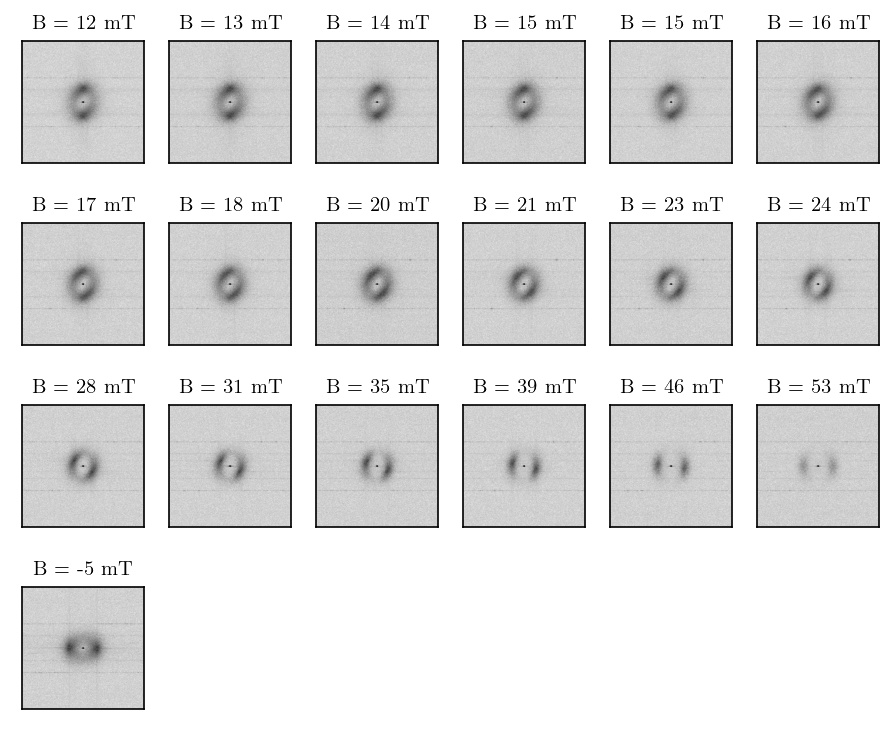

In [11]:
nscans = xmcd.shape[0]

# plt.figure(figsize=(13, 6), dpi = 150)
cols = 6
rows = int(nscans/cols) + nscans % cols
plt.figure(figsize=(6,5), dpi = 150)
tup = []

# Loops to create subplot coordinates
for i in np.arange(0, rows, 1):
        for j in np.arange(0, cols, 1):
            tup.append((i, j))
            
# Plots the same image at different phases.
for i in np.arange(0, nscans, 1):
    ax1 = plt.subplot2grid((rows, cols), tup[i], rowspan=1, colspan=1)
    plt.title('B = %.0lf mT' % (field[i]))
    plt.imshow(S2[i],
           norm=colors.SymLogNorm(linthresh=1e2),
           origin='lower',
           cmap = 'Greys')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

In [12]:
pols = []
for i in np.arange(0, nscans):
    pol, (rads,angs) = topolar(S2[i,:,:])
    pols.append(pol)
pols = np.array(pols)

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.


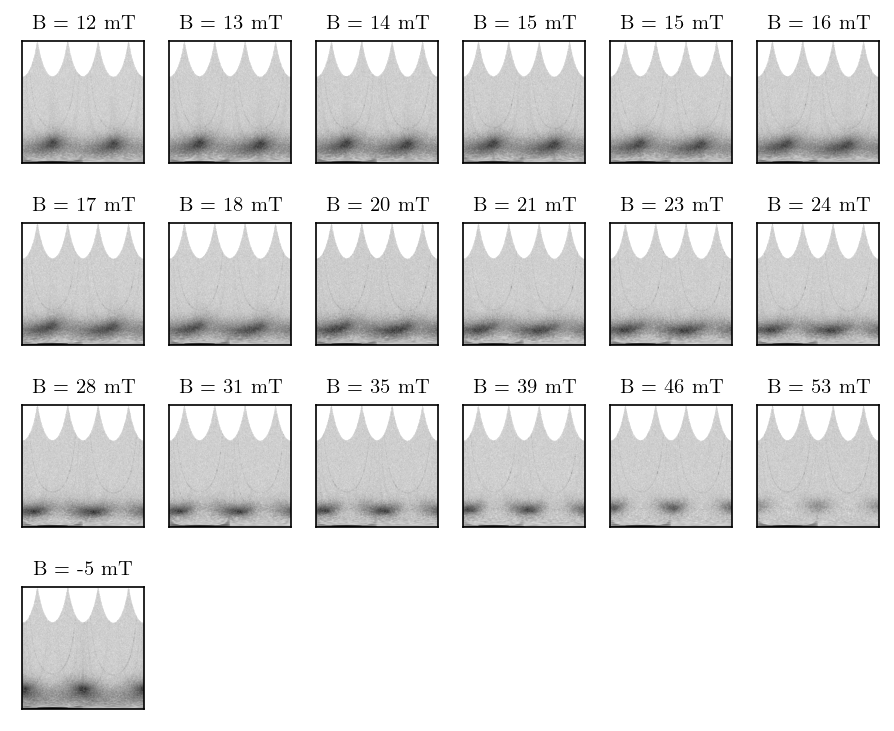

In [13]:
nscans = xmcd.shape[0]

cols = 6
rows = int(nscans/cols) + nscans % cols
plt.figure(figsize=(6,5), dpi = 150)
tup = []

# Loops to create subplot coordinates
for i in np.arange(0, rows, 1):
        for j in np.arange(0, cols, 1):
            tup.append((i, j))
            
# Plots the same image at different phases.
for i in np.arange(0, nscans, 1):
    ax1 = plt.subplot2grid((rows, cols), tup[i], rowspan=1, colspan=1)
    plt.title('B = %.0lf mT' % (field[i]))
    plt.imshow(pols[i],
           norm=colors.SymLogNorm(linthresh=1e2),
           origin='lower',
           cmap = 'Greys')
    plt.xticks([])
    plt.yticks([])
#     plt.colorbar()
plt.tight_layout()
plt.show()

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  app.launch_new_instance()


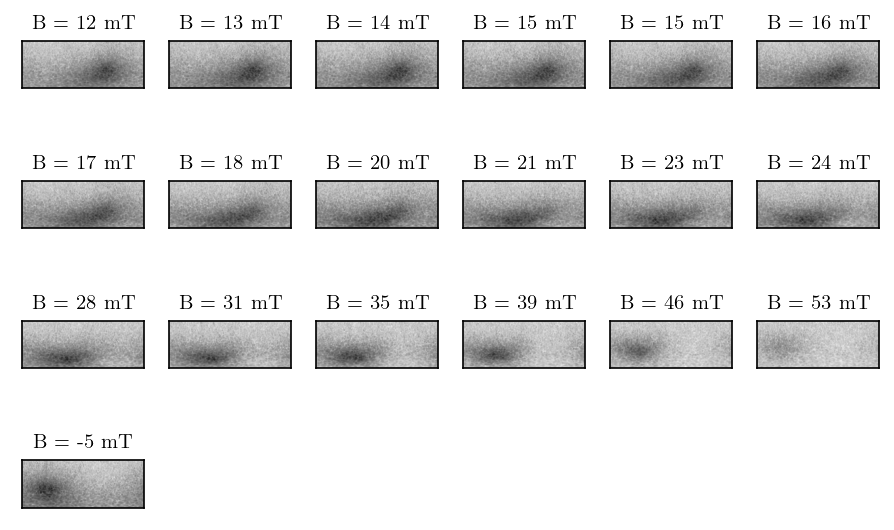

In [14]:
cols = 6
rows = int(nscans/cols) + nscans % cols
plt.figure(figsize=(6,4), dpi = 150)
tup = []

# Loops to create subplot coordinates
for i in np.arange(0, rows, 1):
        for j in np.arange(0, cols, 1):
            tup.append((i, j))
            
# Plots the same image at different phases.
for i in np.arange(0, nscans, 1):
    ax1 = plt.subplot2grid((rows, cols), tup[i], rowspan=1, colspan=1)
    plt.title('B = %.0lf mT' % (field[i]))
    plt.imshow(pols[i],
           norm=colors.SymLogNorm(linthresh=1e2),
           origin='lower',
           cmap = 'Greys')
    plt.ylim([30,100])
    plt.xlim([140,320])
    plt.xticks([])
    plt.yticks([])
#     plt.colorbar()
plt.tight_layout()
plt.show()

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


[3.55057179e+05 2.69024278e+02 1.06667708e+01 2.38951421e+04]
[2.98589829e+05 2.67221989e+02 1.19477989e+01 2.23909457e+04]
[2.69019329e+05 2.66122677e+02 1.26560355e+01 2.25641110e+04]
[2.34010597e+05 2.64870539e+02 1.34490466e+01 2.23360663e+04]
[2.03947452e+05 2.62227073e+02 1.47624857e+01 2.28053033e+04]
[1.70319169e+05 2.58778082e+02 1.76128356e+01 1.99881728e+04]
[ 1.47111958e+05  2.53425803e+02 -2.12252301e+01  1.47836837e+04]
[1.35279114e+05 2.45138255e+02 2.30527717e+01 1.31652449e+04]
[1.27181162e+05 2.37787056e+02 2.36496808e+01 1.12763489e+04]
[1.36563167e+05 2.26263031e+02 2.04614309e+01 1.34199786e+04]
[1.39946744e+05 2.21450021e+02 1.81019070e+01 1.37983609e+04]
[1.40265594e+05 2.17972766e+02 1.61757332e+01 1.32091743e+04]
[1.38344055e+05 2.10565948e+02 1.46289262e+01 9.42062266e+03]
[1.24186864e+05 2.05684864e+02 1.34246274e+01 7.22365625e+03]
[9.54134951e+04 1.99174655e+02 1.48447317e+01 3.39859138e+03]
[8.87874001e+04 1.92453290e+02 1.19380571e+01 3.79267273e+03]
[3.2

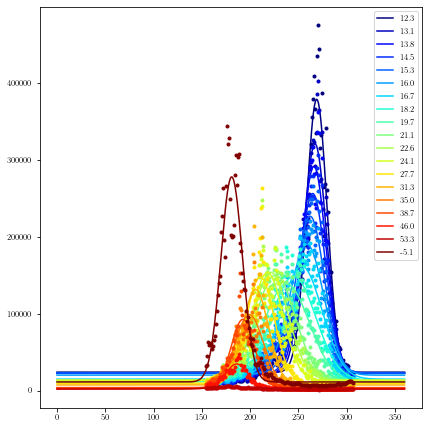

In [15]:
plt.figure(figsize=(6,6))
str_angle = []
widths0 = []
intensity = []
sns.color_palette("Greys", n_colors=10)
color = plt.cm.jet(np.linspace(0,1,nscans))

nscans = xmcd.shape[0]
for i in np.arange(nscans):
    pol_m = np.mean(pols[i][10:,:], axis=0)

    plt.plot(np.rad2deg(angs)[150:300], pol_m[150:300],'.', c=color[i])

    # fit a Gaussian
    xg = np.rad2deg(angs)[150:300]
    yg = pol_m[150:300]
    popt,pcov = curve_fit(gaus,xg,yg,p0=[1e5,230-i,20,0])
    print(popt)
    str_angle.append(popt[1])
    widths0.append(popt[2])
    x = np.rad2deg(angs)
    plt.plot(x,gaus(x,*popt),'-', c=color[i],label='%.1lf' % field[i])
plt.legend()
plt.tight_layout()

In [16]:
field = np.insert(field,0,0)
str_angle = np.insert(str_angle,0,270)
widths0 = np.insert(widths0,0,0)

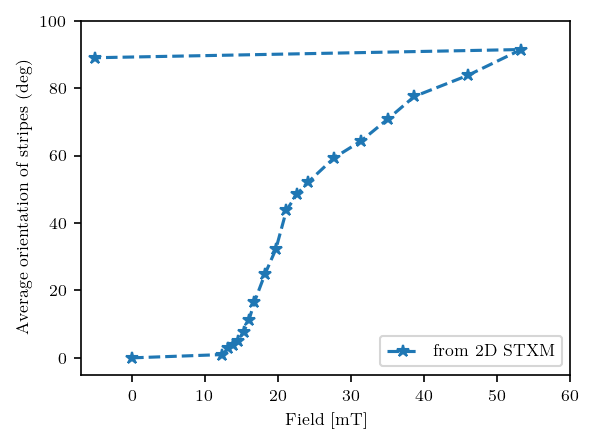

In [17]:
plt.figure(figsize=(4,3), dpi = 150)
plt.ylabel('Average orientation of stripes (deg)')
plt.xlabel('Field [mT]')
plt.plot(field,270-np.array(str_angle),'*--', label='from 2D STXM')
plt.xlim([-7,60])
plt.ylim([-5,100])
plt.legend()
plt.tight_layout()

## Number of Dislocations

In [18]:
Xb = []
Xw = []
dis_black = []
dis_white = []
hh = [24, 25, 26, 27, 28, 29, 30, 32, 34, 36, 38, 40, 45, 50, 55, 60, 70]
for h in hh:
    FILE_NAME = 'Dislocation_positions/xmcd_00_h%d_dislocations_black.dat' % h
    df = pd.read_csv(FILE_NAME, delimiter=',')
    Xb.append(np.array(df.loc[:,'x']))
    dis_black.append(np.array(df.loc[:,'black']))
    FILE_NAME = 'Dislocation_positions/xmcd_00_h%d_dislocations_white.dat' % h
    df = pd.read_csv(FILE_NAME, delimiter=',')
    Xw.append(np.array(df.loc[:,'x']))
    dis_white.append(np.array(df.loc[:,'white']))

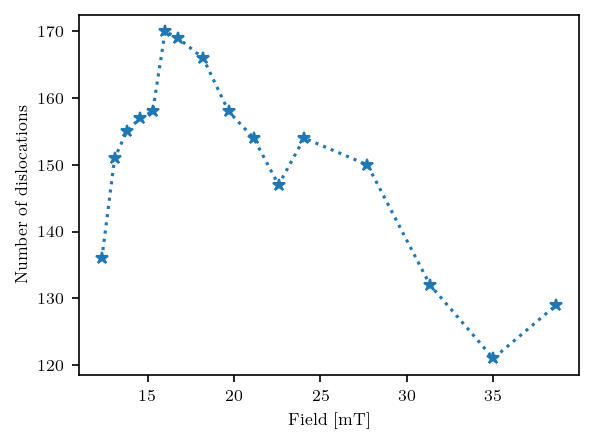

In [20]:
nscans = len(hh)
dis_black_sum = np.zeros((nscans))
dis_white_sum = np.zeros((nscans))
for jj in range(nscans):
    dis_black_sum[jj] = dis_black[jj].shape[0]
    dis_white_sum[jj] = dis_white[jj].shape[0]

all_dis = dis_black_sum + dis_white_sum
# correction after ocular inspection
all_dis[0] += 4
all_dis[1] += 5
all_dis[2] += 1
all_dis[3] += 9
all_dis[4] += 12
all_dis[5] += 5
# all_dis[6] += 
# all_dis[7] += 
all_dis[8] += 6
# all_dis[9] += 
# all_dis[10] += 
all_dis[12] += 8
all_dis[13] += 7
all_dis[14] += 12
all_dis[15] += 6
    
plt.figure(figsize=(4,3), dpi = 150)
plt.plot(field[1:17],all_dis[:16], '*:')
plt.xlabel('Field [mT]')
plt.ylabel('Number of dislocations')
# plt.legend()
plt.tight_layout()

## Average orientation of stripes and number of dislocations vs field

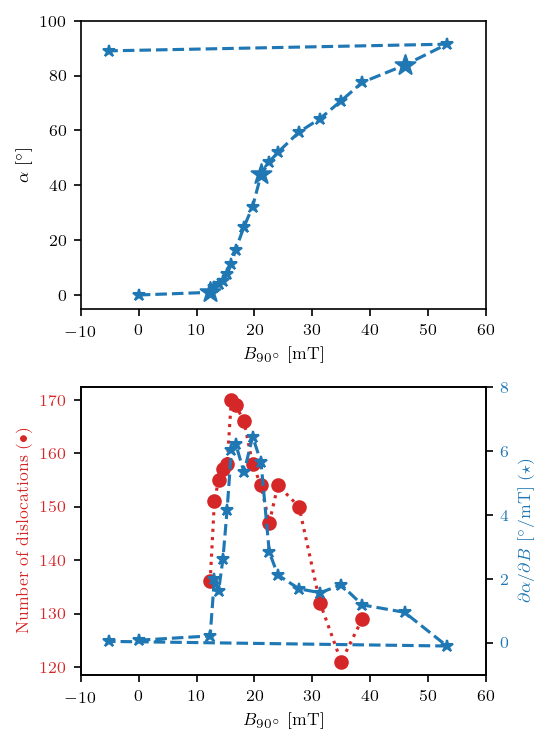

In [21]:
fig, (ax, ax1) = plt.subplots(2,1,figsize=(3.7,5), dpi=150)
ax.set_ylabel('$\\alpha$ [$^{\circ}$]')
ax.set_xlabel('$B_{90^{\circ}}$ [mT]')
ax.plot(field,270-np.array(str_angle),'*--', label='from 2D STXM')
ax.scatter((12.3, 21.1, 46),(1,44,84),marker='*',s=100)
ax.set_xlim([-10,60])
ax.set_ylim([-5,100])

ax1.set_xlabel('$B_{90^{\circ}}$ [mT]')
ax1.set_ylabel('Number of dislocations (\\textbullet)', c='tab:red')
ax1.plot(field[1:17],all_dis[:16], 'o:', c='tab:red', label='#dislocations')
ax1.set_xlim([-10,60])
ax1.tick_params(axis ='y', labelcolor = 'tab:red')

ax2 = ax1.twinx() 
ax2.set_ylabel('$\partial \\alpha / \partial B$ [$^{\circ}$/mT] ($\star$)', c='tab:blue')
ax2.plot(field,-np.gradient(str_angle)/np.gradient(field),'*--', c='tab:blue', label='$\partial\alpha/\partial H$')
ax2.set_xlim([-10,60])
ax2.set_ylim([-1,8])
ax2.set_yticks(np.arange(0,9,2)) 
ax2.tick_params(axis ='y', labelcolor = 'tab:blue') 

plt.tight_layout()
plt.show()